In [1]:
import numpy as np

from astropy.io import fits
from astropy.coordinates import SkyCoord, Angle
from astropy import wcs
from astropy import units as u

from matplotlib import pyplot as plt

from scipy.optimize import curve_fit, leastsq

In [2]:
def binmap(map2d, x, y, rbin):

    '''Bin a 2d map into a 1d symmteric radial profile (i.e. for B_l or radial profile)'''
    X, Y = np.meshgrid(x, y)
    R = np.sqrt(X**2+Y**2)
    print(R.shape)
    d = np.digitize(R.flatten(), rbin)
    rbin1d = np.zeros(len(rbin))
    bin1d = np.zeros(len(rbin))
    binvar = np.zeros(len(rbin))
    binerr = np.zeros(len(rbin))
    for i in range (len(rbin)):
        rbin1d[i] = np.mean(R.flatten()[d==i+1])
        bin1d[i] = np.mean(map2d.flatten()[d==i+1])
        binvar[i] = np.var(map2d.flatten()[d==i+1])
        binerr[i] = np.sqrt(np.var(map2d.flatten()[d==i]) / len(map2d.flatten()[d==i+1]))
    return  rbin1d, bin1d, binvar, binerr

In [3]:
def central_emission(hmap, map_w, pixel_w, max_sep):
    #Returns the average surface brightness in Jy/pixel of pixels within max_sep of the center of hmap (assuming hmap has units MJy/pixel)
    center = map_w + 0.5
    
    emission = 0
    div = 0
    
    for i in range(2*map_w):
        for j in range(2*map_w):
            if pixel_w*np.sqrt((center-i)**2+(center-j)**2) <= max_sep:
                emission += hmap[i,j]
                div +=1
    return emission, div

In [4]:
path = '/project/r/rbond/jorlo/Reductions/data/'

#MS0736
#fname = 'amp_1_amp_2_amp_poly_sub_pred2_data__initial_svd.fits'

#MOO1142
fname = 'MOO_1142FP-First_Pord2_v0_2020-06-24_nFFT1_TS_EaCMS0f0_51_17_Feb_2020-_svd20-2_arcsec_autograd_initial_svd.fits'

hdu = fits.open(path+fname)
data = hdu[0].data

w = wcs.WCS(hdu[0].header, hdu)

In [5]:

#MS0735 cent
#cur_center = SkyCoord(Angle('07 41 44.5 hours').to(u.radian).value, Angle('74:14:38.7 degrees').to(u.radian).value, unit = "rad")

#MOO1142
cur_center = SkyCoord(3.0665111128123264, 0.2697068189809627, unit = 'rad')
x,y = wcs.utils.skycoord_to_pixel(cur_center, w)

x, y = round(x.item()), round(y.item())

In [6]:
bounds = 15

In [7]:
zoom_data = data[y-bounds:y+bounds, x-bounds:x+bounds]

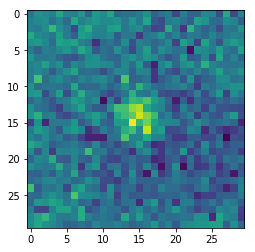

In [8]:
plt.imshow(zoom_data)#, vmin = -1e-3, vmax = 1e-3)

In [9]:
rbin1d, bin1d, binvar, binerr = binmap(zoom_data, np.linspace(-bounds+1, bounds-1, bounds*2), np.linspace(-bounds+1, bounds-1, bounds*2), rbin = np.linspace(0, bounds, bounds))

binerr[0] = binerr[1] #gotta fix that

(30, 30)


/gpfs/fs1/home/r/rbond/jorlo/intel-jax/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3622: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/gpfs/fs1/home/r/rbond/jorlo/intel-jax/lib/python3.6/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/gpfs/fs1/home/r/rbond/jorlo/intel-jax/lib/python3.6/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [12]:
binerr

array([1.13601577e-04, 1.13601577e-04, 9.36488487e-05, 5.57842978e-05,
       5.60518547e-05, 5.61215286e-05, 5.07690214e-05, 4.27314796e-05,
       4.74471497e-05, 3.66659588e-05, 3.27979068e-05, 3.42858331e-05,
       3.60032383e-05, 3.53970286e-05, 2.70679226e-05])

<ErrorbarContainer object of 3 artists>

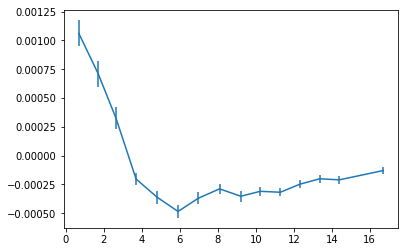

In [10]:


plt.errorbar(rbin1d, bin1d, yerr=binerr)

In [13]:
def gauss(x, *p):
    #print(p)
    A, sigma, m, b = p
    return A*np.exp(-(x)**2/(2.*sigma**2))+m*x + b
residual = lambda p, x, y, yerr: (gauss(x, *p)-y)/yerr

In [21]:
# p0 is the initial guess for the fitting coefficients (A, mu and sigma above)
p0 = [1., 1., 0.001, -.0001]

#pf, var_matrix = curve_fit(gauss, rbin1d, bin1d, p0=p0)
pf, cov, info, mesg, success = leastsq(residual, p0,
                                                args=(rbin1d, bin1d, binerr), full_output=1)


In [22]:
pf

array([ 1.78346944e-03,  1.99251463e+00,  2.73855128e-05, -5.90570358e-04])

<ErrorbarContainer object of 3 artists>

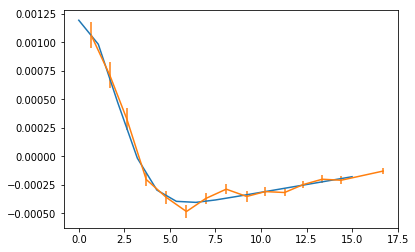

In [19]:
rbin = np.linspace(0, bounds, bounds)

plt.plot(rbin, gauss(rbin, *pf))
plt.errorbar(rbin1d, bin1d, yerr=binerr)

In [24]:
0.00055555555555556*pf[1]

0.0011069525713592436